# 用python分析《三国演义》中的社交网络

一直以来对自然语言处理和社交网络分析都很感兴趣，前者能帮助我们从文本中获得很多发现，而后者能够让我们对人们和各个事物之间普遍存在的网络般地联系有更多地认识。当二者结合，又会有怎样的魔力呢？

作为一个三国迷，我就有了这样的想法：能不能用文本处理的方法，得到小说中人物社交网络，再进行分析呢？python中有很多好工具能够帮助我实践我好奇地想法，现在就开始动手吧。

In [1]:
import os
import re
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
# matplotlib显示中文和负号问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from harvesttext import HarvestText
from harvesttext.resources import *

## 准备工作及小范围尝试

获得《三国演义》的文本。

In [2]:
chapters = get_sanguo()                 # 文本列表，每个元素为一章的文本
print(chapters[0][:106])

第一回 宴桃园豪杰三结义　斩黄巾英雄首立功

  
	滚滚长江东逝水，浪花淘尽英雄。是非成败转头空。

	青山依旧在，几度夕阳红。

	白发渔樵江渚上，惯看秋月春风。一壶浊酒喜相逢。

	古今多少事，都付笑谈中。


《三国演义》并不是很容易处理的文本，它接近古文，我们会面对古人的字号等一系列**别名**。比如电脑怎么知道“玄德”指的就是“刘备”呢？那就要我们给它一些**知识**。我们人通过学习知道“玄德”是刘备的字，电脑也可以用类似的方法完成这个概念的连接。我们需要告诉电脑，“刘备”是实体（类似于一个对象的标准名），而“玄德”则是“刘备”的一个指称，告诉的方式，就是提供电脑一个**知识库**。

In [3]:
entity_mention_dict, entity_type_dict = get_sanguo_entity_dict()
print("刘备的指称有：",entity_mention_dict["刘备"])

刘备的指称有： ['刘备', '刘玄德', '玄德', '使君']


除了人的实体和指称以外，我们也能够包括三国势力等别的类型的指称，比如“蜀”又可以叫“蜀汉”，所以知识库里还可以包括实体的类型信息来加以区分。

In [4]:
print("刘备的类型为",entity_type_dict["刘备"])
print("蜀的类型为",entity_type_dict["蜀"])
print("蜀的指称有",entity_mention_dict["蜀"])

刘备的类型为 人名
蜀的类型为 势力
蜀的指称有 ['蜀', '蜀汉']


有了这些知识，理论上我们就可以编程联系起实体的各个绰号啦。不过若是要从头做起的话，其中还会有不少的工作量。而HarvestText[1]是一个封装了这些步骤的文本处理库，可以帮助我们轻松完成这个任务。

In [5]:
ht = HarvestText()
ht.add_entities(entity_mention_dict, entity_type_dict)      # 加载模型
print(ht.seg("誓毕，拜玄德为兄，关羽次之，张飞为弟。",standard_name=True))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\KELEN\AppData\Local\Temp\jieba.cache
Loading model cost 1.025 seconds.
Prefix dict has been built succesfully.


['誓毕', '，', '拜', '刘备', '为兄', '，', '关羽', '次之', '，', '张飞', '为弟', '。']


成功地把指称统一到标准的实体名以后，我们就可以着手挖掘三国的社交网络了。具体的建立方式是利用**邻近共现**关系。每当一对实体在两句话内同时出现，就给它们加一条边。那么建立网络的整个流程就如同下图所示：

![网络建模过程示意.png](./images/网络建模过程示意.png)

我们可以使用HarvestText提供的函数直接完成这个流程，让我们先在第一章的小文本上实践一下：

In [6]:
# 准备工作
doc = chapters[0].replace("操","曹操")                                  # 由于有时使用缩写，这里做一个微调
ch1_sentences = ht.cut_sentences(doc)     # 分句
doc_ch01 = [ch1_sentences[i]+ch1_sentences[i+1] for i in range(len(ch1_sentences)-1)]  #获得所有的二连句
ht.set_linking_strategy("freq")

In [7]:
# 建立网络
G = ht.build_entity_graph(doc_ch01, used_types=["人名"])              # 对所有人物建立网络，即社交网络

In [8]:
def draw_graph(G,alpha,node_scale,figsize):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=[G.degree[x]*node_scale for x in G.nodes])
    nx.draw_networkx_edges(G,pos,alpha=alpha)
    nx.draw_networkx_labels(G,pos)
    plt.axis("off")
    plt.show()

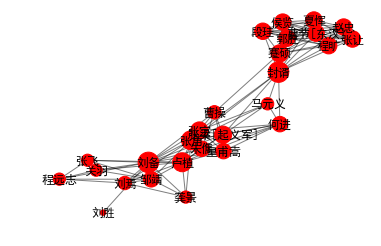

In [9]:
# 挑选主要人物画图
important_nodes = [node for node in G.nodes if G.degree[node]>=5]
G_sub = G.subgraph(important_nodes).copy()
draw_graph(G_sub,alpha=0.5,node_scale=30,figsize=(6,4))

他们之间具体有什么关系呢？我们可以利用文本摘要得到本章的具体内容：

In [10]:
stopwords = get_baidu_stopwords()    #过滤停用词以提高质量

In [11]:
for i,doc in enumerate(ht.get_summary(doc_ch01, topK=3, stopwords=stopwords)):
	print(i,doc)

0 玄德见皇甫嵩、朱儁，具道卢植之意。嵩曰：“张梁、张宝势穷力乏，必投广宗去依张角。
1 	时张角贼众十五万，植兵五万，相拒于广宗，未见胜负。植谓玄德曰：“我今围贼在此，贼弟张梁、张宝在颍川，与皇甫嵩、朱儁对垒。
2 	次日，于桃园中，备下乌牛白马祭礼等项，三人焚香再拜而说誓曰：“念刘备、关羽、张飞，虽然异姓，既结为兄弟，则同心协力，救困扶危；上报国家，下安黎庶。不求同年同月同日生，只愿同年同月同日死。


本章的主要内容，看来就是刘关张桃园三结义，并且共抗黄巾贼的故事。

## 获得全《三国演义》的社交网络

有了小范围实践的基础，我们就可以用同样的方法，整合每个章节的内容，画出一张横跨三国各代的大图。

In [12]:
G_chapters = []
for chapter in chapters:
    sentences = ht.cut_sentences(chapter)     # 分句
    docs = [sentences[i]+sentences[i+1] for i in range(len(sentences)-1)]
    G_chapters.append(ht.build_entity_graph(docs, used_types=["人名"]))

In [13]:
# 合并各张子图
G_global = nx.Graph()
for G0 in G_chapters:
    for (u,v) in G0.edges:
        if G_global.has_edge(u,v):
            G_global[u][v]["weight"] += G0[u][v]["weight"]
        else:
            G_global.add_edge(u,v,weight=G0[u][v]["weight"])

In [14]:
# 忽略游离的小分支只取最大连通分量
largest_comp = max(nx.connected_components(G_global), key=len)
G_global = G_global.subgraph(largest_comp).copy()
print(nx.info(G_global))

Name: 
Type: Graph
Number of nodes: 1290
Number of edges: 10096
Average degree:  15.6527


整个社交网络有1310个人那么多，还有上万条边！那么我们要把它画出来几乎是不可能的，那么我们就挑选其中的关键人物来画出一个子集吧。

In [15]:
important_nodes = [node for node in G_global.nodes if G_global.degree[node]>=30]
G_main = G_global.subgraph(important_nodes).copy()

用**pyecharts**进行可视化

In [16]:
from pyecharts import Graph
nodes = [{"name": "结点1", "value":0, "symbolSize": 10} for i in range(G_main.number_of_nodes())]
for i,name0 in enumerate(G_main.nodes):
    nodes[i]["name"] = name0
    nodes[i]["value"] = G_main.degree[name0]
    nodes[i]["symbolSize"] = G_main.degree[name0] / 10.0
links = [{"source": "", "target": ""} for i in range(G_main.number_of_edges())]
for i,(u,v) in enumerate(G_main.edges):
    links[i]["source"] = u
    links[i]["target"] = v
    links[i]["value"] = G_main[u][v]["weight"]

graph = Graph("三国人物关系力导引图")
graph.add("", nodes, links)
graph.render("./images/三国人物关系力导引图.html")
graph

截图：显示了刘备的邻接结点
![net](./images/三国人物社交网络.JPG)

整个网络错综复杂，背后是三国故事中无数的南征北伐、尔虞我诈。不过有了计算机的强大算力，我们依然可以从中梳理出某些关键线索，比如：

## **谁是三国中最重要的人物？**

对这个问题，我们可以用网络中的排序算法解决。**PageRank**就是这样的一个典型方法，它本来是搜索引擎利用网站之间的联系对搜索结果进行排序的方法，不过对人物之间的联系也是同理。让我们获得最重要的20大人物：

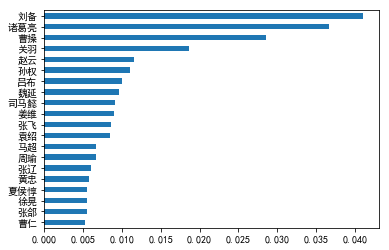

In [17]:
page_ranks = pd.Series(nx.algorithms.pagerank(G_global)).sort_values()
page_ranks.tail(20).plot(kind="barh")
plt.show()

《三国演义》当仁不让的主角就是他们了，哪怕你对三国不熟悉，也一定会对这些人物耳熟能详。

## 谁是三国中最有权力的人？

这个问题看上去跟上面一个问题很像，但其实还是有区别的。就像人缘最好的人未必是领导一样，能在团队中心起到凝聚作用，使各个成员相互联系合作的人才是最有权力的人。**中心度**就是这样的一个指标，看看三国中最有权力的人是哪些吧？

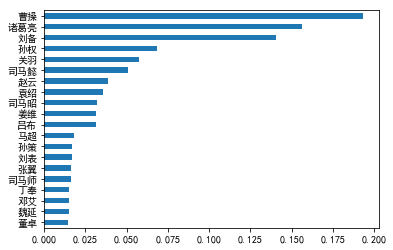

In [18]:
between = pd.Series(nx.betweenness_centrality(G_global)).sort_values()
between.tail(20).plot(kind="barh")
plt.show()

结果的确和上面的排序有所不同，我们看到刘备、曹操、孙权、袁绍等主公都名列前茅。而另一个有趣的发现是，司马懿、司马昭、司马师父子三人同样榜上有名，而曹氏的其他后裔则不见其名，可见司马氏之权倾朝野。**司马氏之心，似乎就这样被大数据揭示了出来！**

## 三国人物之间的集团关系怎样？

人物关系有亲疏远近，因此往往会形成一些集团。社交网络分析里的**社区发现算法**就能够让我们发现这些集团，让我使用community库[2]中的提供的算法来揭示这些关系吧。

In [19]:
import community                                    # python-louvain
partition = community.best_partition(G_main)         # Louvain算法划分社区
comm_dict = defaultdict(list)
for person in partition:
    comm_dict[partition[person]].append(person)

In [20]:
def draw_community(comm):
    G_comm = G_main.subgraph(comm_dict[comm]).copy()
    draw_graph(G_comm,alpha=0.2,node_scale=10,figsize=(8,6))
    print("community {}: {}".format(str(comm)," ".join(reversed(sorted(comm_dict[comm],key=G_global.degree)))))

在下面3个社区里，我们看到的主要是魏蜀吴三国重臣们。（有趣的是，电脑并不知道他们的所属势力，而是纯粹通过算法得到的。）

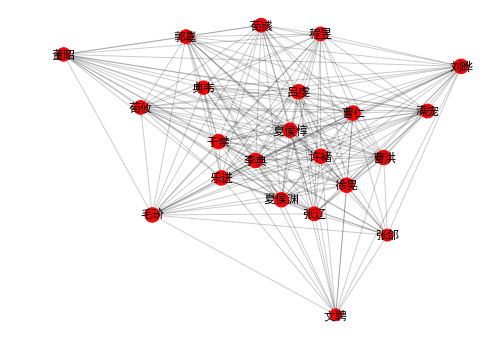

community 2: 张辽 曹仁 夏侯惇 徐晃 曹洪 夏侯渊 张郃 许褚 乐进 李典 于禁 荀彧 刘晔 郭嘉 满宠 程昱 荀攸 吕虔 典韦 文聘 董昭 毛玠


In [22]:
draw_community(2)

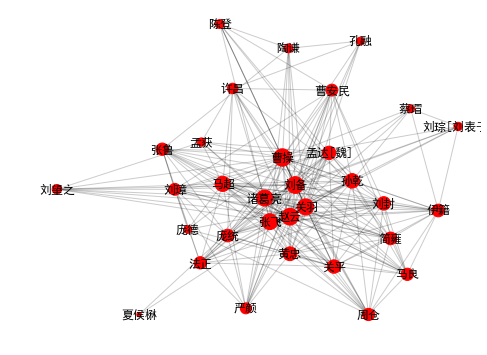

community 4: 曹操 诸葛亮 刘备 关羽 赵云 张飞 马超 黄忠 许昌 孟达[魏] 孙乾 曹安民 刘璋 关平 庞德 法正 伊籍 张鲁 刘封 庞统 孟获 严颜 马良 简雍 蔡瑁 陶谦 孔融 刘琮[刘表子] 刘望之 夏侯楙 周仓 陈登


In [29]:
draw_community(4)

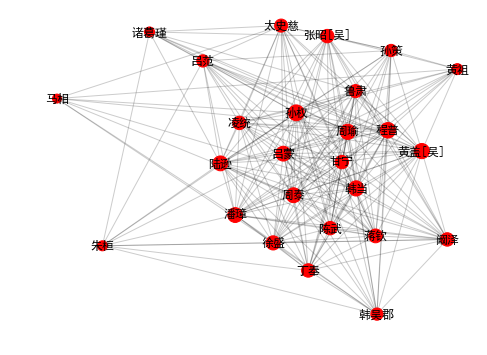

community 3: 孙权 孙策 周瑜 陆逊 吕蒙 丁奉 周泰 程普 韩当 徐盛 张昭[吴] 马相 黄盖[吴] 潘璋 甘宁 鲁肃 凌统 太史慈 诸葛瑾 韩吴郡 蒋钦 黄祖 阚泽 朱桓 陈武 吕范


In [21]:
draw_community(3)

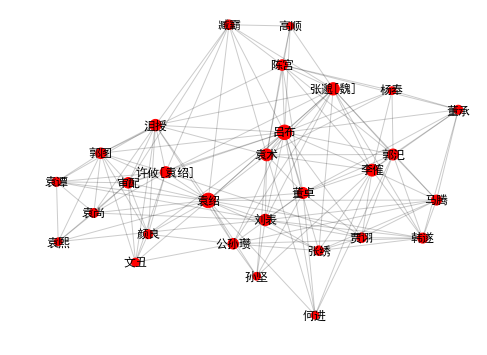

community 0: 袁绍 吕布 刘表 袁术 董卓 李傕 贾诩 审配 孙坚 郭汜 陈宫 马腾 袁尚 韩遂 公孙瓒 高顺 许攸[袁绍] 臧霸 沮授 郭图 颜良 杨奉 张绣 袁谭 董承 文丑 何进 张邈[魏] 袁熙


In [24]:
draw_community(0)

而在这个社区里，我们看到三国前期，孙坚、袁绍、董卓等主公们群雄逐鹿，好不热闹。

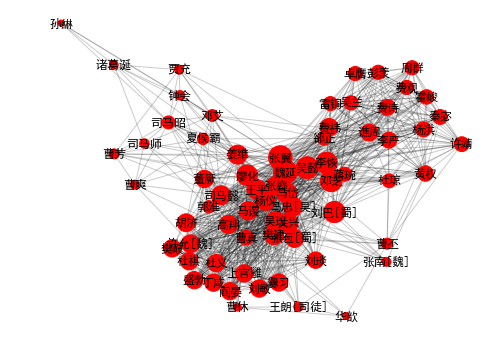

community 1: 司马懿 魏延 姜维 张翼 马岱 廖化 吴懿 司马昭 关兴 吴班 王平 邓芝 邓艾 张苞[蜀] 马忠[吴] 费祎 谯周 马谡 曹真 曹丕 李恢 黄权 钟会 蒋琬 司马师 刘巴[蜀] 张嶷 杨洪 许靖 费诗 李严 郭淮 曹休 樊建 秦宓 夏侯霸 杨仪 高翔 张南[魏] 华歆 曹爽 郤正 许允[魏] 王朗[司徒] 董厥 杜琼 霍峻 胡济 贾充 彭羕 吴兰 诸葛诞 雷铜 孙綝 卓膺 费观 杜义 阎晏 盛勃 刘敏 刘琰 杜祺 上官雝 丁咸 爨习 樊岐 曹芳 周群


In [23]:
draw_community(1)

这个社区是三国后期的主要人物了。这个网络背后的故事，是司马氏两代三人打败姜维率领的蜀汉群雄，又扫除了曹魏内部的曹家势力，终于登上权力的顶峰。

## 随时间变化的社交网络

研究社交网络随时间的变化，是个很有意思的任务。而《三国演义》大致按照时间线叙述，且有着极长的时间跨度，顺着故事线往下走，社交网络会发生什么养的变化呢？

这里，我取10章的文本作为跨度，每5章记录一次当前跨度中的社交网络，就相当于留下一张快照，把这些快照连接起来，我们就能够看到一个社交网络变化的动画。快照还是用networkx得到，而制作动画，我们可以用moviepy。

江山代有才人出，让我们看看在故事发展的各个阶段，都是哪一群人活跃在舞台中央呢？

In [25]:
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
width, step = 10,5
range0 = range(0,len(G_chapters)-width+1,step)
numFrame, fps = len(range0), 1
duration = numFrame/fps
pos_global = nx.spring_layout(G_main)

def make_frame_mpl(t):
    i = step*int(t*fps)
    G_part = nx.Graph()
    for G0 in G_chapters[i:i+width]:
        for (u,v) in G0.edges:
            if G_part.has_edge(u,v):
                G_part[u][v]["weight"] += G0[u][v]["weight"]
            else:
                G_part.add_edge(u,v,weight=G0[u][v]["weight"])
    largest_comp = max(nx.connected_components(G_part), key=len)
    used_nodes = set(largest_comp) & set(G_main.nodes)
    G = G_part.subgraph(used_nodes)
    fig = plt.figure(figsize=(12,8),dpi=100)
    nx.draw_networkx_nodes(G,pos_global,node_size=[G.degree[x]*10 for x in G.nodes])
#     nx.draw_networkx_edges(G,pos_global)
    nx.draw_networkx_labels(G,pos_global)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.axis("off")
    plt.title(f"第{i+1}到第{i+width+1}章的社交网络")
    return mplfig_to_npimage(fig)
animation = mpy.VideoClip(make_frame_mpl, duration=duration)

In [26]:
animation.write_gif("./images/三国社交网络变化.gif", fps=fps)


[MoviePy] Building file ./images/三国社交网络变化.gif with imageio


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:07<00:00,  3.15it/s]


美观起见，动画中省略了网络中的边。

![gif](./images/三国社交网络变化.gif)

随着时间的变化，曾经站在历史舞台中央的人们也渐渐地会渐渐离开，让人不禁唏嘘感叹。正如《三国演义》开篇所言：

*古今多少事，都付笑谈中。*

今日，小辈利用python做的一番笑谈也就到此结束吧……

注：

\[0\] 本文受到了数据森麟前面的[《“水泊梁山“互联网有限公司一百单八将内部社交网络》](https://mp.weixin.qq.com/s/OpR_FXt2pDdrj6U4JmIcDw) 极大的启发，很高兴能够接触到这些有趣的数据分析，和这一群有趣的人~

\[1\] harvesttext是本人的作品~\(\*^__^\*) ~，已在[Github](https://github.com/blmoistawinde/HarvestText)上开源并可通过pip直接安装，旨在帮助使用者更轻易地完成像本文这样的文本数据分析。除了本文涉及的功能以外，还有文本摘要和情感分析等功能。大家觉得有用的话，不妨亲身尝试下，看看能不能在自己感兴趣的文本上有更多有趣有用的发现呢？

[2]commutity库的本名是python-louvain，使用了和Gephi内置相同的Louvain算法进行社区发现

[3]由于处理古文的困难性，本文中依然有一些比较明显的错误，希望大家不要介意~